# Data Mapping

### Import


In [1]:
import pandas as pd
import numpy as np
import unicodedata
import matplotlib.pyplot as plt
import seaborn as sns   
from joblib import Parallel, delayed
import sys
sys.path.append("..")
from rapidfuzz import fuzz, process



In [16]:
def clean_price_column(data, col):
    """Clean and convert price columns to integers."""
    data[col] = data[col].str.strip().str.replace('₫', '').str.replace('.', '').astype(int)

    return data

In [17]:
data_winmart_1 = pd.read_excel('./data/raw/BHX_Winmart/Gia_Winmart_2022-12-01.xlsx').drop(['Sell unit'], axis = 1)
data_winmart_2 = pd.read_excel('./data/raw/BHX_Winmart/Gia_Winmart_2022-12-15.xlsx').drop(['Sell unit'], axis = 1)
data_bhx_1 = pd.read_excel('./data/raw/BHX_Winmart/Gia_BHX_2022-12-01.xlsx').drop(['Sku','Barcode','DateUpdate'], axis = 1)
data_bhx_2 = pd.read_excel('./data/raw/BHX_Winmart/Gia_BHX_2022-12-15.xlsx').drop(['Sku','Barcode','DateUpdate'], axis = 1)
data_bhx_2.rename(columns = {'Gia':'Giá'}, inplace= True)

data_winmart_1 = clean_price_column(data_winmart_1,"Giá")
data_winmart_2 = clean_price_column(data_winmart_2,"Giá")
data_bhx_1 = clean_price_column(data_bhx_1,"Giá")
data_bhx_2 = clean_price_column(data_bhx_2,"Giá")

## FUZZY MATCHING


In [18]:
data_winmart = data_winmart_1.merge(data_winmart_2,on = ['Tên sản phẩm','Category_link','Url'], how = 'outer')
data_bhx = data_bhx_1.merge(data_bhx_2,on = ['Tên sản phẩm','LinkCategory','LinkSku'], how = 'outer')
data_winmart = data_winmart.rename(columns = {'Giá_x':'Giá_01','Giá_y':'Giá_15'})
data_bhx = data_bhx.rename(columns = {'Giá_x':'Giá_01','Giá_y':'Giá_15'})

In [19]:
data_winmart['Category'] = data_winmart['Category_link'].apply(lambda x: x.split(".vn/")[-1])
data_bhx['Category'] = data_bhx['LinkCategory'].apply(lambda x: x.split(".com/")[-1])
data_winmart = data_winmart.drop(columns = 'Category_link')
data_bhx = data_bhx.drop(columns = 'LinkCategory')

replacements_BHX = {
    'dau-goi': 'Chăm sóc tóc',
    'ca-phe-tra': 'Đồ uống',
    'mi':'Mì gói',
    'nuoc-giat-bot-giat-nuoc-tay':'Nước tẩy rửa',
    'dau-goi-dau-xa-duong-toc':'Chăm sóc tóc',
    'ca-phe-lon':'Đồ uống',
    'nuoc-giat':'Nước tẩy rửa',
    'mi-pho-chao-an-lien':'Đồ ăn liền',
    'ca-phe-hoa-tan':'Đồ uống',
    'nuoc-rua-chen':'Nước tẩy rửa',
    'mi-nui-bun-kho':'Thực phẩm',
    'ca-phe-phin':'Đồ uống',
    'nuoc-giat-cho-tre':'Nước tẩy rửa',
    'nuoc-giat-xa-cho-be':'Nước tẩy rửa',
    'mi-chay':'Mì chay'
}
replacements_Winmart = {
    'mi-thuc-pham-an-lien--c34':'Đồ ăn liền',
    'mi--c01145': 'Mì gói',
    'cham-soc-toc--c0145': 'Chăm sóc tóc',
    'nuoc-giat--c01140': 'Nước tẩy rửa',
    'mien-hu-tiu-banh-canh--c01148':'Thực phẩm',
    'ca-phe--c01162':'Đồ uống',
    'nuoc-rua-chen--c01142':'Nước tẩy rửa',
    'pho-bun--c01147':'Thực phẩm'
}

def map_categories(data, category_col, replacements):
    """Map categories based on a dictionary."""
    data['NewCategory'] = data[category_col].map(replacements).fillna(data[category_col])
    data = data.drop(columns=[category_col]).rename(columns={'NewCategory': 'Category'})
    return data

data_winmart = map_categories(data_winmart,'Category',replacements_Winmart)
data_bhx = map_categories(data_bhx,'Category',replacements_BHX)

In [20]:
print(data_bhx.duplicated().sum() +data_winmart.duplicated().sum())
data_bhx = data_bhx.drop_duplicates()
data_winmart = data_winmart.drop_duplicates()
print(data_bhx.duplicated().sum() +data_winmart.duplicated().sum())

6
0


In [21]:
data_merge = data_winmart.merge(data_bhx, on = ['Category'], how = 'outer', suffixes = ('_winmart','_bhx')).drop(columns = ['Url','LinkSku'])
data_merge.head(5)

,Tên sản phẩm_winmart,Giá_01_winmart,Giá_15_winmart,Category,Tên sản phẩm_bhx,Giá_01_bhx,Giá_15_bhx
0,Dầu Gội Pantene Suôn Mượt Óng Ả chai...,259000.0,NaN,Chăm sóc tóc,5 dây Dầu gội Clear Men bạc hà mát lạnh 4.9ml ...,72000.0,72000.0
1,Dầu Gội Pantene Suôn Mượt Óng Ả chai...,259000.0,NaN,Chăm sóc tóc,5 dây Dầu gội Ôliv chắc khoẻ 5.8ml,76000.0,76000.0
2,Dầu Gội Pantene Suôn Mượt Óng Ả chai...,259000.0,NaN,Chăm sóc tóc,5 dây dầu gội Dove phục hồi hư tổn 5.8ml x 12 gói,86000.0,86000.0
3,Dầu Gội Pantene Suôn Mượt Óng Ả chai...,259000.0,NaN,Chăm sóc tóc,5 dây dầu gội Head & Shoulders 5.7ml x 10 gói,91000.0,91000.0
4,Dầu Gội Pantene Suôn Mượt Óng Ả chai...,259000.0,NaN,Chăm sóc tóc,5 dây dầu gội Pantene ngăn rụng tóc 5.8ml x 10...,91000.0,91000.0


In [22]:
data_merge.dropna(inplace = True)
data_merge.describe( include = 'all')

,Tên sản phẩm_winmart,Giá_01_winmart,Giá_15_winmart,Category,Tên sản phẩm_bhx,Giá_01_bhx,Giá_15_bhx
count,30316,30316.000000,30316.000000,30316,30316,3.031600e+04,3.031600e+04
unique,203,NaN,NaN,4,596,NaN,NaN
top,Cà phê đen hòa tan G7 hộp 30g,NaN,NaN,Mì gói,Thùng 24 gói miến Phú Hương thịt bằm 55g,NaN,NaN
freq,312,NaN,NaN,24910,190,NaN,NaN
mean,NaN,56663.814487,56025.544267,NaN,NaN,5.306229e+04,5.372047e+04
std,NaN,81192.394401,79831.903907,NaN,NaN,1.058311e+05,1.113538e+05
min,NaN,3000.000000,3000.000000,NaN,NaN,2.900000e+03,3.200000e+03
25%,NaN,10400.000000,10700.000000,NaN,NaN,8.200000e+03,8.200000e+03
50%,NaN,24700.000000,25250.000000,NaN,NaN,1.300000e+04,1.330000e+04
75%,NaN,57000.000000,54900.000000,NaN,NaN,4.000000e+04,4.300000e+04


| **Trường hợp**             | **Hàm phù hợp**           | **Mô tả**                                                      |
| -------------------------- | ------------------------- | -------------------------------------------------------------- |
| **So khớp tên đầy đủ**     | `fuzz.ratio`              | So sánh toàn bộ chuỗi, phù hợp khi hai chuỗi giống hệt.        |
| **So khớp một phần**       | `fuzz.partial_ratio`      | So sánh một phần chuỗi, thích hợp cho tên dài.                 |
| **Bỏ qua thứ tự từ**       | `fuzz.token_sort_ratio`   | Sắp xếp từ và so sánh, phù hợp với `Oreo Bánh` và `Bánh Oreo`. |
| **Loại bỏ từ trùng lặp**   | `fuzz.token_set_ratio`    | Bỏ qua từ lặp và so sánh tập hợp từ.                           |
| **Tên sản phẩm có mã SKU** | `fuzz.partial_token_sort` | So sánh từng phần, thích hợp khi có mã sản phẩm.               |


In [3]:

# ======== 🔍 1. Hàm so khớp (Fuzzy Matching) ========
def fuzzy_match(query, choices, scorer=fuzz.token_set_ratio, cutoff=80, top_n=1):
    return process.extract(query, choices, scorer=scorer, limit=top_n, score_cutoff=cutoff)

# ======== ⚙️ 2. Hàm xử lý nhóm (Blocking & Matching) ========
def process_group(source_group, target_group, source_col, target_col, groupby=None, scorer=fuzz.token_set_ratio, cutoff=80, top_n=1):
    """Xử lý so khớp trong từng nhóm danh mục."""
    results = []

    source_products = source_group[source_col].dropna().unique()
    target_products = target_group[target_col].dropna().unique()

    # So khớp từng sản phẩm
    for source_product in source_products:
        best_matches = fuzzy_match(source_product, target_products, scorer, cutoff, top_n)

        # Ghi kết quả nếu tìm thấy
        for match, score, _ in best_matches:
            results.append({
                source_col: source_product,
                target_col: match,
                'Similarity %': f"{score}%",
            })

    return results

# ======== 🚀 3. Hàm ánh xạ sản phẩm ========
def map_products(source_df, source_col, target_df, target_col, groupby=None, scorer=fuzz.token_set_ratio, cutoff=80, top_n=1, n_jobs=-1):
    """
    Ánh xạ sản phẩm thông minh giữa hai DataFrame.
    Hỗ trợ groupby theo danh mục và xử lý song song.
    """
    if groupby and groupby in source_df.columns and groupby in target_df.columns:
        grouped_results = Parallel(n_jobs=n_jobs)(
            delayed(process_group)(
                source_group, target_df[target_df[groupby] == category],
                source_col, target_col, groupby, scorer, cutoff, top_n
            )
            for category, source_group in source_df.groupby(groupby)
        )
        results = [item for sublist in grouped_results for item in sublist]
    else:
        results = process_group(source_df, target_df, source_col, target_col, groupby, scorer, cutoff, top_n)

    return pd.DataFrame(results)

mapped = map_products(
    source_df=data_merge,
    source_col='Tên sản phẩm_winmart',
    target_df=data_merge,
    target_col='Tên sản phẩm_bhx',
    # groupby='Category',
    scorer=fuzz.token_set_ratio,
    cutoff=100,
    top_n=1,
    n_jobs=-1
)
print(mapped.count())
mapped.head(10)


NameError: name 'data_merge' is not defined

In [24]:
mapped.to_csv('../data/processed/product_mapping.csv', index=False)
mapped = mapped.merge(data_merge, on = ['Tên sản phẩm_winmart','Tên sản phẩm_bhx'], how='inner')
mapped.head(10)


OSError: Cannot save file into a non-existent directory: '..\data\processed'

In [ ]:
# Filter products with different prices between the two stores
mapped["diff_01"] = mapped['Giá_01_winmart'] - mapped['Giá_01_bhx']
mapped["diff_15"] = mapped['Giá_15_winmart'] - mapped['Giá_15_bhx']


In [ ]:
mapped.drop(columns = ['Giá_01_winmart','Giá_15_winmart', 'Giá_01_bhx','Giá_15_bhx'], inplace = True)
mapped.head(10)

,Tên sản phẩm_winmart,Tên sản phẩm_bhx,Similarity %,Category,diff_01,diff_15
0,Hảo Hảo Mì lẩu kim chi Hàn Quốc 75g,Mì Hảo Hảo lẩu kim chi Hàn Quốc gói 75g,100.0%,Mì gói,300.0,100.0
1,Mì Kool Cung Đình trộn trứng muối 90g,Mì trộn Cung Đình Kool trứng muối hộp 90g,100.0%,Mì gói,-900.0,-900.0
2,Mì Nấu bò nấu cay Omachi 10gói x 100g,Mì nấu Omachi bò cay 100g,100.0%,Mì gói,70800.0,70800.0
3,Mì Omachi sườn hầm ngũ quả 92g,Mì khoai tây Omachi sườn hầm ngũ quả hộp 92g,100.0%,Mì gói,-800.0,-2600.0
4,Mì Omachi trộn xốt Spaghetti 105g,Mì trộn Omachi xốt Spaghetti hộp 105g,100.0%,Mì gói,181400.0,180300.0
5,Mì Ottogi Jin tương đen vị bò 135g,Mì tương đen Jin Ottogi vị bò gói 135g,100.0%,Mì gói,1400.0,1400.0
6,Mì Sutah bò cay Samyang gói 120g,Mì bò cay Samyang Sutah Ramen gói 120g,100.0%,Mì gói,600.0,-1400.0
7,Mì gói khô gà cay Carbonara Samyang 130g,Mì khô gà cay Samyang Carbonara gói 130g,100.0%,Mì gói,300.0,1900.0
8,Mì gói ăn liền vị gà cay Samyang 145g,Mì gà cay Samyang gói 145g,100.0%,Mì gói,3300.0,500.0
9,Mì khoai tây Omachi vị sườn hầm ngũ quả thịt l...,Mì khoai tây Omachi sườn hầm ngũ quả ly 113g,100.0%,Mì gói,396400.0,396400.0


In [ ]:
# Tính toán IQR để xác định giá trị ngoại lai
Q1 = mapped['diff_01'].quantile(0.25)
Q3 = mapped['diff_01'].quantile(0.75)
IQR = Q3 - Q1

# Xác định giới hạn dưới và giới hạn trên
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Lọc bỏ các giá trị ngoại lai
filtered_mapped = mapped[(mapped['diff_01'] >= lower_bound) & (mapped['diff_01'] <= upper_bound)]
# In ra giá trị ngoại lai
outliers = mapped[(mapped['diff_01'] < lower_bound) | (mapped['diff_01'] > upper_bound)]
# Hiển thị kết quả
filtered_mapped.head()

,Tên sản phẩm_winmart,Tên sản phẩm_bhx,Similarity %,Category,diff_01,diff_15
0,Hảo Hảo Mì lẩu kim chi Hàn Quốc 75g,Mì Hảo Hảo lẩu kim chi Hàn Quốc gói 75g,100.0%,Mì gói,300.0,100.0
1,Mì Kool Cung Đình trộn trứng muối 90g,Mì trộn Cung Đình Kool trứng muối hộp 90g,100.0%,Mì gói,-900.0,-900.0
3,Mì Omachi sườn hầm ngũ quả 92g,Mì khoai tây Omachi sườn hầm ngũ quả hộp 92g,100.0%,Mì gói,-800.0,-2600.0
5,Mì Ottogi Jin tương đen vị bò 135g,Mì tương đen Jin Ottogi vị bò gói 135g,100.0%,Mì gói,1400.0,1400.0
6,Mì Sutah bò cay Samyang gói 120g,Mì bò cay Samyang Sutah Ramen gói 120g,100.0%,Mì gói,600.0,-1400.0


In [ ]:
outliers

,Tên sản phẩm_winmart,Tên sản phẩm_bhx,Similarity %,Category,diff_01,diff_15
2,Mì Nấu bò nấu cay Omachi 10gói x 100g,Mì nấu Omachi bò cay 100g,100.0%,Mì gói,70800.0,70800.0
4,Mì Omachi trộn xốt Spaghetti 105g,Mì trộn Omachi xốt Spaghetti hộp 105g,100.0%,Mì gói,181400.0,180300.0
9,Mì khoai tây Omachi vị sườn hầm ngũ quả thịt l...,Mì khoai tây Omachi sườn hầm ngũ quả ly 113g,100.0%,Mì gói,396400.0,396400.0
12,Mì khô gà cay vị phô mai Samyang gói 140g,Mì khô gà cay Samyang gói 140g,100.0%,Mì gói,6700.0,3700.0
25,Cà phê hòa tan đen đá 2in1 G7 Trung Nguyên hộp...,Cà phê đen đá G7 2in1 240g,100.0%,Đồ uống,-4600.0,-4600.0


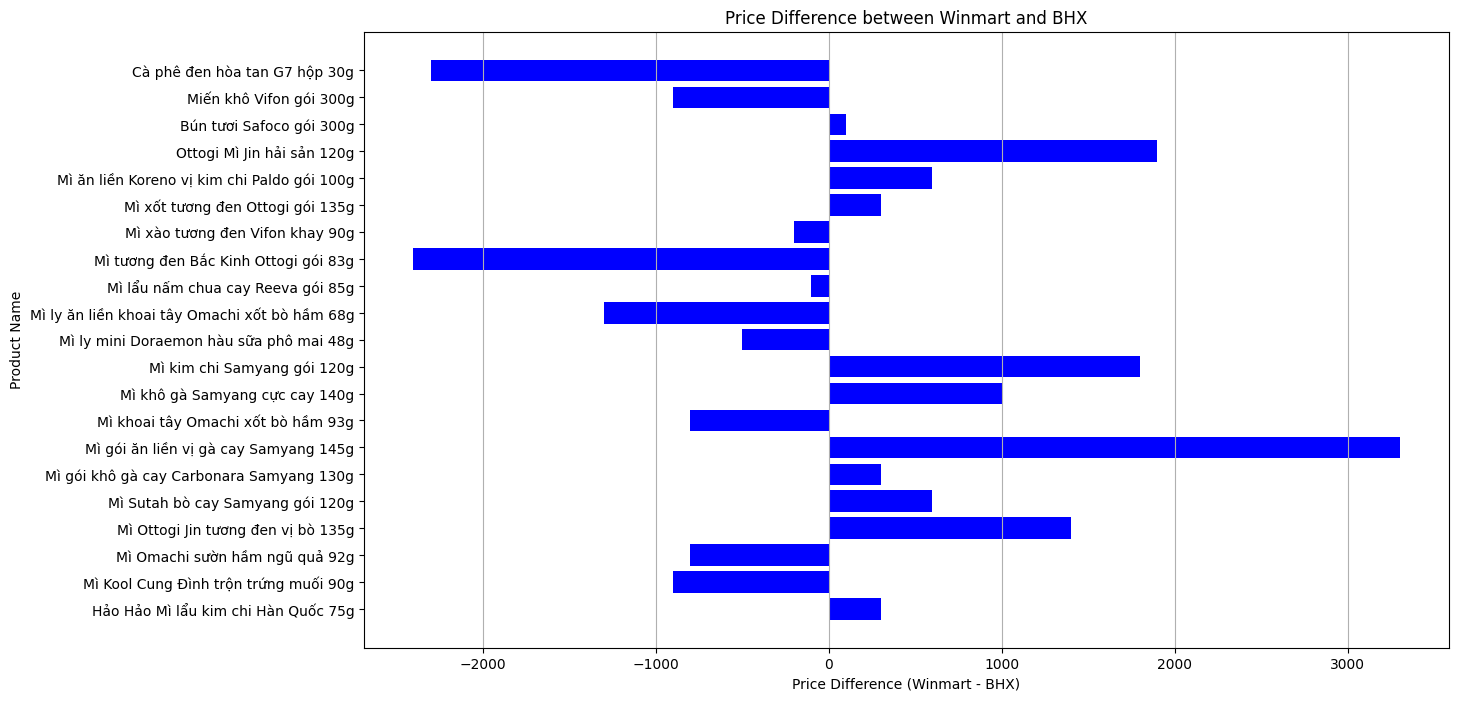

In [ ]:

# Lọc dữ liệu để lấy các sản phẩm có sự khác biệt giá
price_diff_df = filtered_mapped[filtered_mapped['diff_01'] != 0]

# Vẽ biểu đồ so sánh
plt.figure(figsize=(14, 8))
plt.barh(price_diff_df['Tên sản phẩm_winmart'], price_diff_df['diff_01'], color='blue')
plt.xlabel('Price Difference (Winmart - BHX)')
plt.ylabel('Product Name')
plt.title('Price Difference between Winmart and BHX')
plt.grid(axis='x')
plt.show()

In [ ]:
mf_df = pd.read_excel('../data/raw/BHX_Winmart/manuf_data.xlsx') 
rt_df = pd.read_excel('../data/raw/BHX_Winmart/retailer_data.xlsx') 


In [ ]:
rt_df.rename(columns = {'Product_Description':'Description'}, inplace = True)

In [ ]:
rs = map_products(
    source_df=mf_df,
    source_col='Description',
    target_df=rt_df,
    target_col='Description',
    scorer=fuzz.token_set_ratio,
    cutoff=100,
    top_n=1,
    n_jobs=-1
)
rs

,Description,Similarity %
0,Cbvery Extra Hold Hairspray 400ml,100.0%
1,Cbvery Freeze Hold Hairspray 400ml,100.0%
2,Oddaced Rework Putty 150ml,100.0%
3,Oddaced Mega Hold Gel Spray 200ml,100.0%
4,Oddaced Ultimate Hold Hairspray 400ml,100.0%
5,Cbvery Firm Hold Hairspray 400ml,100.0%
6,6Good Gentle Care Shampoo 400ml,100.0%
7,Oddaced Curl Defining Mousse 200ml,100.0%
8,Oddaced Gel Wax 75ml,100.0%
9,Oddaced Give Me Moisture Shampoo 250ml,100.0%


In [ ]:
rs.count()

Description     16
Similarity %    16
dtype: int64

## CLUSTERING VS NLP
